<a href="https://colab.research.google.com/github/HWANG-HOE-SUN/bigcon/blob/master/%EB%AA%A8%EB%8D%B8%EB%A7%81%ED%86%B5%ED%95%A9%EB%B0%8F%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [3]:
#한글폰트 지정
plt.rc('font', family='NanumBarunGothic') 

In [4]:
total = pd.read_excel('/content/drive/My Drive/빅콘폴더/2020_bigcontest_champion_performance.xlsx', header=1)
total = total[total['상품군']!='무형'] 
total = total[total['판매단가'] < total['취급액']]
total['날짜'] = pd.to_datetime(total['방송일시']).dt.date
total['날짜'] = pd.to_datetime(total['날짜'])
total['주문량'] = total['취급액']/total['판매단가']
total["요일"]=total["방송일시"].dt.dayofweek # 요일
total["시"]=total["방송일시"].dt.hour # 시
total['월'] = total['방송일시'].dt.month # 월

In [5]:
total = total.fillna(method='ffill')

In [6]:
total = total[total['취급액']!=50000]
total.reindex(range(len(total)))

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,날짜,주문량,요일,시,월
0,2019-01-01 06:00:00,20.0,100346.0,201072.0,테이트 남성 셀린니트3종,의류,39900.0,2099000.0,2019-01-01,52.606516,1.0,6.0,1.0
1,2019-01-01 06:00:00,20.0,100346.0,201079.0,테이트 여성 셀린니트3종,의류,39900.0,4371000.0,2019-01-01,109.548872,1.0,6.0,1.0
2,2019-01-01 06:20:00,20.0,100346.0,201072.0,테이트 남성 셀린니트3종,의류,39900.0,3262000.0,2019-01-01,81.754386,1.0,6.0,1.0
3,2019-01-01 06:20:00,20.0,100346.0,201079.0,테이트 여성 셀린니트3종,의류,39900.0,6955000.0,2019-01-01,174.310777,1.0,6.0,1.0
4,2019-01-01 06:40:00,20.0,100346.0,201072.0,테이트 남성 셀린니트3종,의류,39900.0,6672000.0,2019-01-01,167.218045,1.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35374,2019-12-10 10:40:00,20.0,100129.0,200340.0,뱅뱅 남성 본딩기모데님3종,의류,99000.0,23492000.0,2019-12-10,237.292929,1.0,10.0,12.0
35375,2019-12-10 10:40:00,20.0,100129.0,200351.0,뱅뱅 여성 본딩기모데님3종,의류,99000.0,15706000.0,2019-12-10,158.646465,1.0,10.0,12.0
35376,2019-12-10 11:00:00,20.0,100129.0,200340.0,뱅뱅 남성 본딩기모데님3종,의류,99000.0,32268000.0,2019-12-10,325.939394,1.0,11.0,12.0
35377,2019-12-10 11:00:00,20.0,100129.0,200351.0,뱅뱅 여성 본딩기모데님3종,의류,99000.0,19072000.0,2019-12-10,192.646465,1.0,11.0,12.0


In [7]:
total['상품군'].unique()

array(['의류', '속옷', '주방', '농수축', '이미용', '가전', '생활용품', '건강기능', '잡화', '가구',
       '침구'], dtype=object)

# 데이터 생성

In [8]:
train = pd.read_excel('/content/drive/My Drive/빅콘폴더/최종 데이터셋 후보/train.xlsx')
train = train[train['판매단가'] < train['취급액']]

In [9]:
train['노출(분)'] = train['노출(분)'].replace(0, math.nan)
train['노출(분)'] = train['노출(분)'].fillna(method='ffill')

In [10]:
train.index = np.arange(7513)

In [11]:
test = pd.read_excel('/content/drive/My Drive/빅콘폴더/test.xlsx', header=1)

In [12]:
data = pd.read_excel('/content/drive/My Drive/빅콘폴더/2020_bigcontest_champion_performance.xlsx', header=1)
data = data[data['상품군']!='무형'] 
data = data[data['판매단가'] < data['취급액']]
data['날짜'] = pd.to_datetime(data['방송일시']).dt.date
data['날짜'] = pd.to_datetime(data['날짜'])
data['주문량'] = data['취급액']/data['판매단가']
data["요일"]=data["방송일시"].dt.dayofweek # 요일
data["시"]=data["방송일시"].dt.hour # 시
data['월'] = data['방송일시'].dt.month # 월
weekday = {"월":0,"화":1,"수":2,"목":3,"금":4,"토":5,"일":6}

In [13]:
data = data.fillna(method='ffill')

In [14]:
data = data.iloc[17604:25792]

# 날씨 처리

In [15]:
# 대표 지역들
places = ["강릉","광주","부산","수원","울산","대구","대전","서울","파주"] 
weather = pd.read_excel("/content/drive/My Drive/빅콘폴더/날씨_실제/강릉날씨.xlsx")
row_num = weather.shape[0]
weather["지역"]=["강릉"]*row_num

In [16]:
# 모든 지역 날씨 데이터 세로로 합치기
for p in places[1:]:
    a=pd.read_excel(f"/content/drive/My Drive/빅콘폴더/날씨_실제/{p}날씨.xlsx")
    a["지역"]=[p]*row_num
    weather = pd.concat([weather, a], axis=0)

In [17]:
# "-" -> 0값으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].replace("-",0)
weather["신적설(cm)"]=weather["신적설(cm)"].replace("-",0)
weather["운량(1/10)"]=weather["운량(1/10)"].replace("-",0)

# object 형 float 형으로 변경
weather["강수량(mm)"]=weather["강수량(mm)"].astype(float)
weather["신적설(cm)"]=weather["신적설(cm)"].astype(float)
weather["운량(1/10)"]=weather["운량(1/10)"].astype(float)

In [18]:
weather = weather.reset_index()

In [19]:
# 날짜 set 맞추기
new_weather = pd.DataFrame()
new_weather = weather.iloc[165:243]
new_weather = pd.concat([new_weather, weather.iloc[753:831]])
new_weather = pd.concat([new_weather, weather.iloc[1341:1419]])
new_weather = pd.concat([new_weather, weather.iloc[1929:2007]])
new_weather = pd.concat([new_weather, weather.iloc[2517:2595]])
new_weather = pd.concat([new_weather, weather.iloc[3105:3183]])
new_weather = pd.concat([new_weather, weather.iloc[3693:3771]])
new_weather = pd.concat([new_weather, weather.iloc[4281:4359]])
new_weather = pd.concat([new_weather, weather.iloc[4869:4947]])

In [20]:
# 서울 날씨와 강릉, 부산 날씨로 칼럼별 주문량 상관성 확인 및 지역별 날씨의 영향도 확인
gang_weather = new_weather.loc[new_weather["지역"]=="강릉",:]
seoul_weather = new_weather.loc[new_weather["지역"]=="서울",:]
busan_weather = new_weather.loc[new_weather["지역"]=="부산",:]
suwon_weather = new_weather.loc[new_weather["지역"]=="수원",:]
sudogwon_weather = new_weather.loc[(new_weather["지역"]=="서울")|(weather["지역"]=="수원"),:]

In [21]:
day_data = data.copy()

In [22]:
day_data['날짜'] = pd.to_datetime(day_data['날짜'])
new_weather['날짜'] = pd.to_datetime(new_weather['날짜'])

In [23]:
all_data = day_data.merge(new_weather, on='날짜')
all_data = all_data.groupby(['날짜']).mean()

In [24]:
sudogwon_weather['날짜'] = pd.to_datetime(sudogwon_weather['날짜'] )
seoul_weather['날짜'] = pd.to_datetime(seoul_weather['날짜'] )
busan_weather['날짜'] =pd.to_datetime(busan_weather['날짜'] )
suwon_weather['날짜'] = pd.to_datetime(suwon_weather['날짜'] )
gang_weather['날짜'] = pd.to_datetime(gang_weather['날짜'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [25]:
sudogwon_data = day_data.merge(sudogwon_weather, on="날짜")
suwon_data = day_data.merge(suwon_weather, on="날짜")
seoul_data = day_data.merge(seoul_weather, on="날짜")
busan_data = day_data.merge(busan_weather, on="날짜")
gang_data = day_data.merge(gang_weather, on="날짜")

In [26]:
fc_prop = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/강수확률.csv")
fc_amount = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/6시간 강수량.csv") 
fc_sky = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/하늘상태.csv")
fc_top = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최고기온.csv")
fc_bottom = pd.read_csv("/content/drive/My Drive/빅콘폴더/날씨예보/서울날씨/일최저기온.csv")

In [27]:
forecast_data = {"강수확률":fc_prop, "강수량":fc_amount,"하늘상태":fc_sky, "일최고기온":fc_top, "일최저기온":fc_bottom}

In [28]:
forecast = pd.DataFrame()

for name, fcdata in forecast_data.items():
    amount_list=[]
    cycle = (fcdata.shape[0])//365 # 하루 관측량
    for i in range(365):
        day_weather = fcdata.iloc[i*cycle:(i+1)*cycle,-1].mean()
        amount_list.append(day_weather)
    forecast[name]=amount_list

In [29]:
forecast = forecast.iloc[165:243]

In [30]:
# 날짜 칼럼 추가
forecast["날짜"]=train["날짜"].unique()

# 마더코드, 일/월별 처리

In [31]:
def hand_by_momcode(data):
  momcodegroup = data.groupby(['마더코드']).sum()
  momcodegroup['주문량/노출'] = momcodegroup['주문량']/momcodegroup['노출(분)']
  topcode = list(momcodegroup.sort_values('주문량/노출', ascending=False).index[:50]) #탑50개
  return topcode

In [32]:
hand_by_momcode(train) # train으로 topcode생성

[100492,
 100499,
 100046,
 100754,
 100323,
 100253,
 100844,
 100523,
 100019,
 100167,
 100841,
 100452,
 100026,
 100829,
 100818,
 100777,
 100021,
 100322,
 100511,
 100416,
 100822,
 100172,
 100455,
 100348,
 100589,
 100166,
 100165,
 100074,
 100197,
 100403,
 100327,
 100281,
 100460,
 100015,
 100588,
 100169,
 100318,
 100755,
 100275,
 100010,
 100479,
 100202,
 100612,
 100009,
 100319,
 100773,
 100747,
 100171,
 100109,
 100849]

- 상품군내 마더코드별 주문량

In [33]:
multi_grouped = train.groupby(['상품군','마더코드'])
MultiGroup = multi_grouped['주문량'].sum()
MultiGroup = MultiGroup.reset_index()

In [34]:
item = list(set(MultiGroup['상품군']))

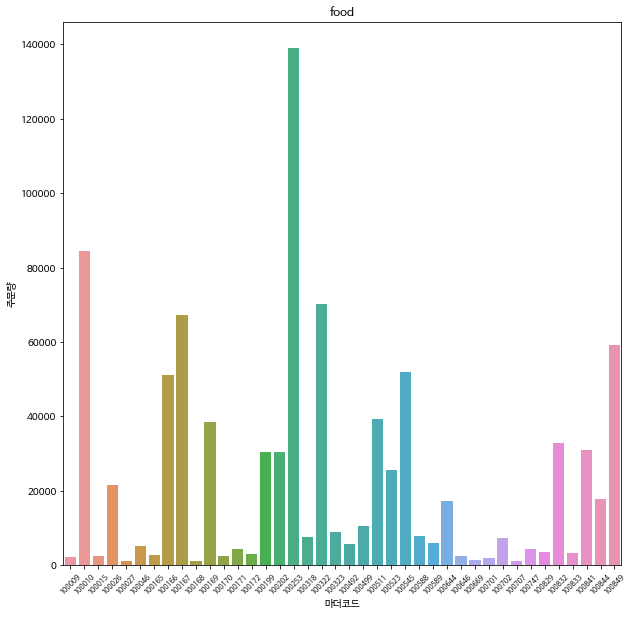

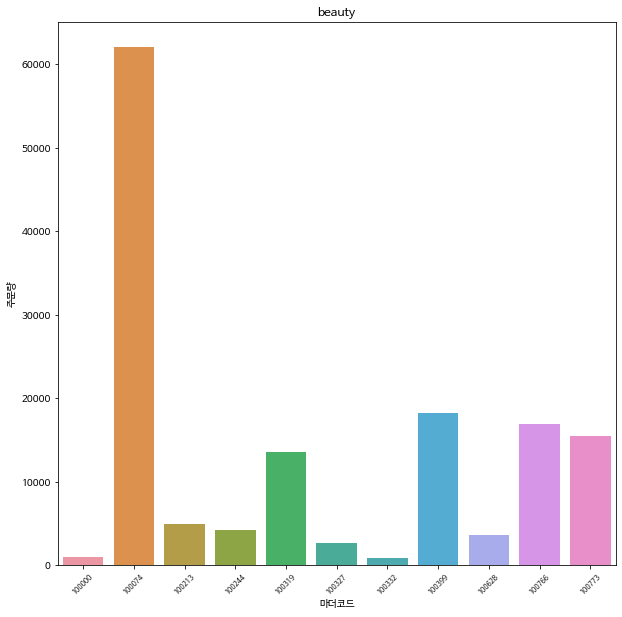

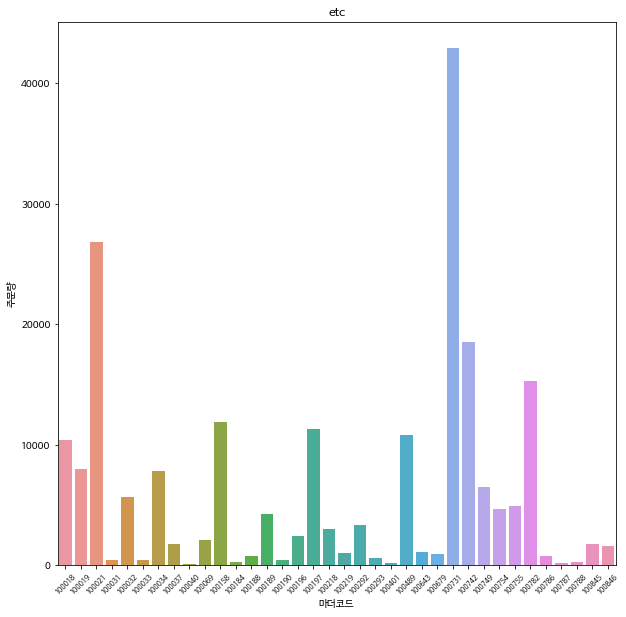

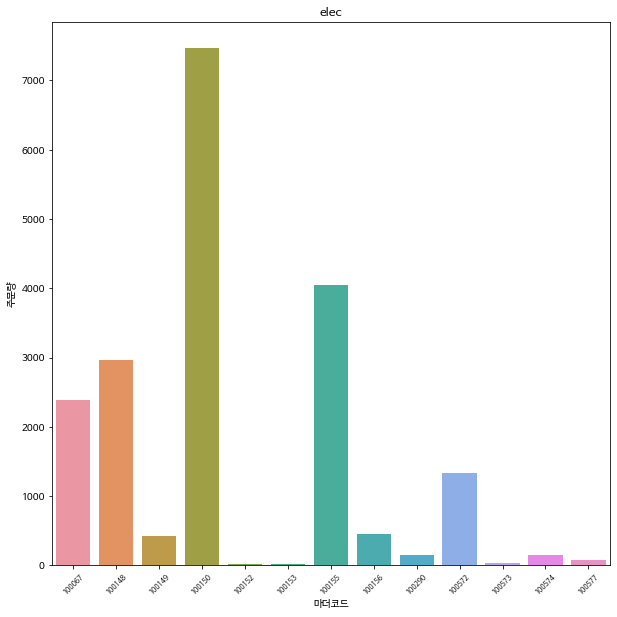

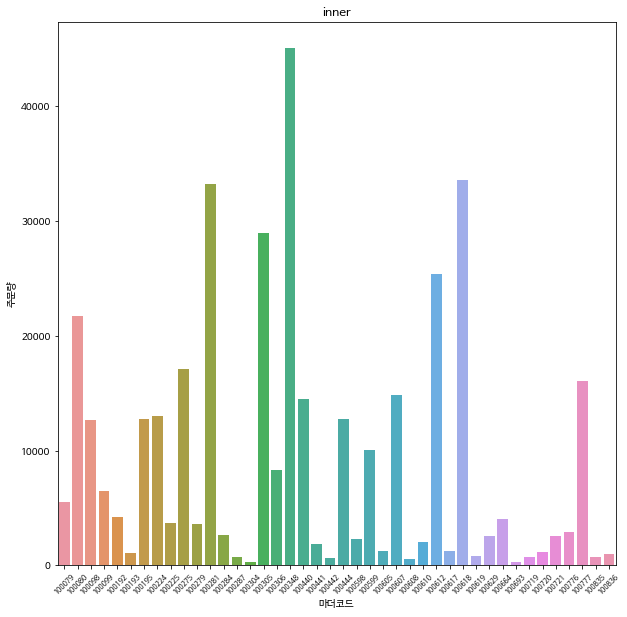

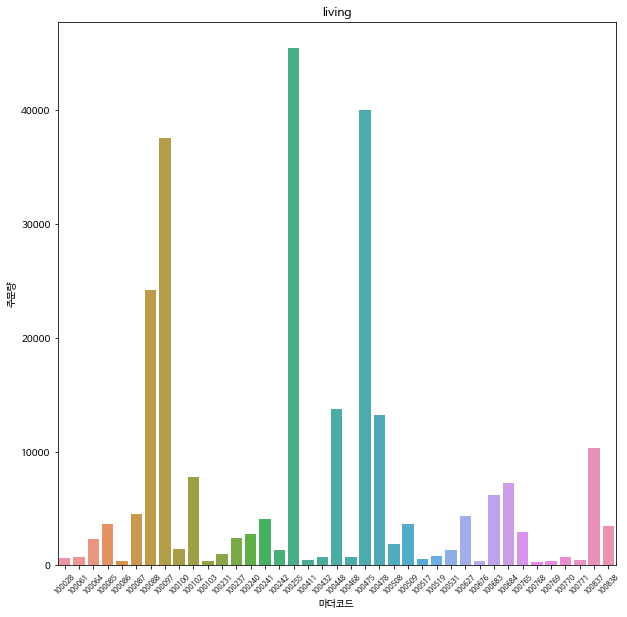

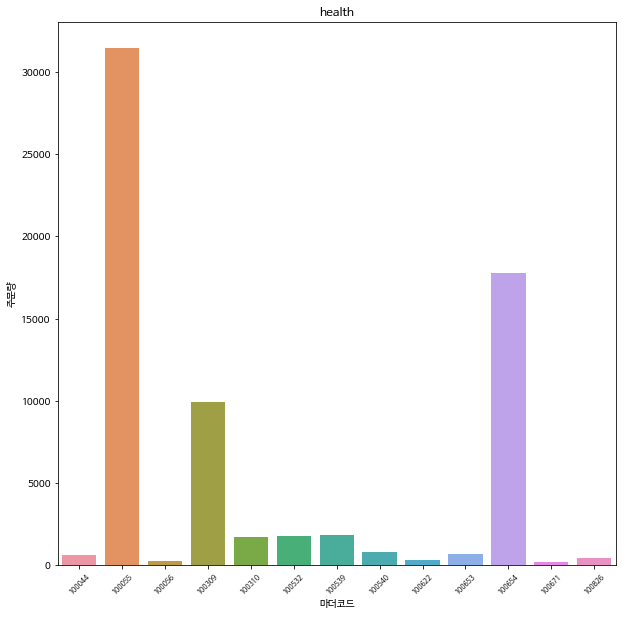

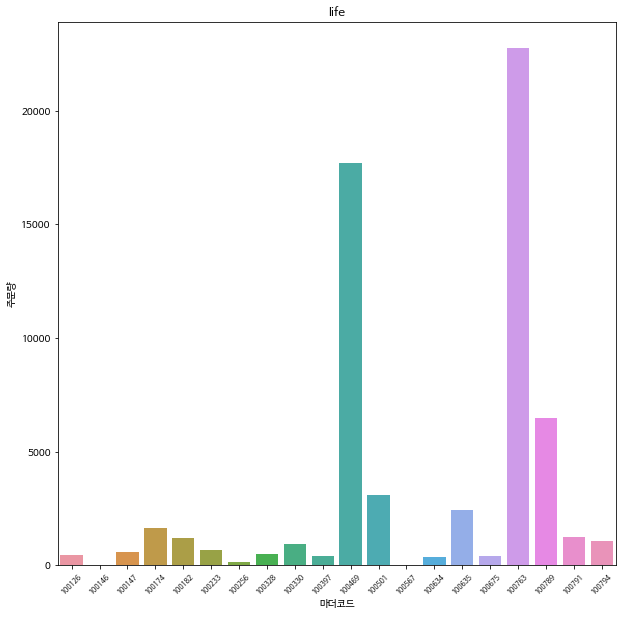

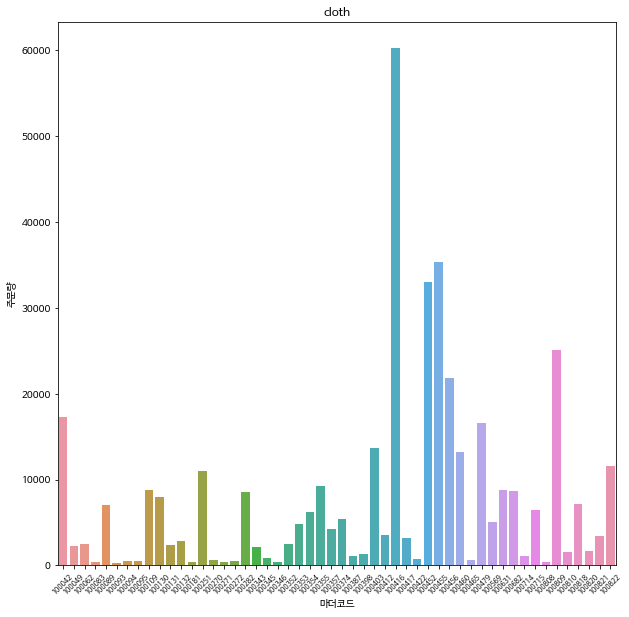

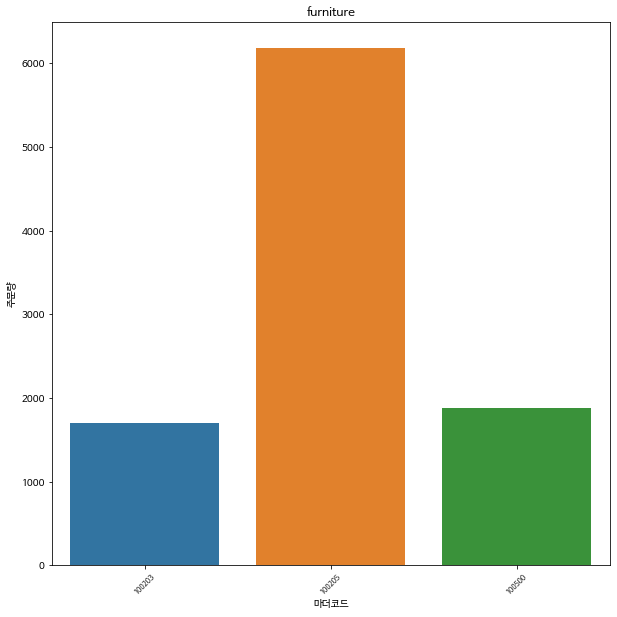

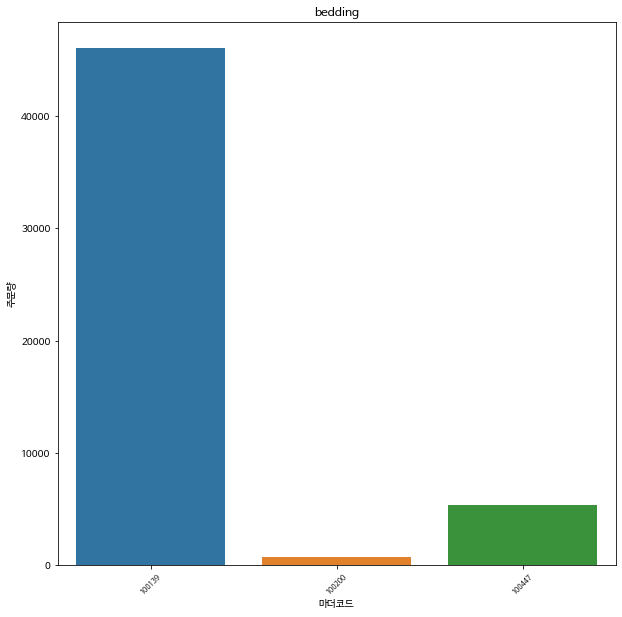

In [35]:
for i in item:
    plt.figure(figsize=(10,10))
    sns.barplot(data=MultiGroup[MultiGroup['상품군']==i], x='마더코드', y='주문량')
    plt.title(i)
    plt.xticks(rotation=45, size=7)

- 시간대 상품군별 주문량

In [36]:
hour_grouped = train.groupby(['시','상품군'])
HourGroup = hour_grouped['주문량'].sum()
HourGroup = HourGroup.reset_index()

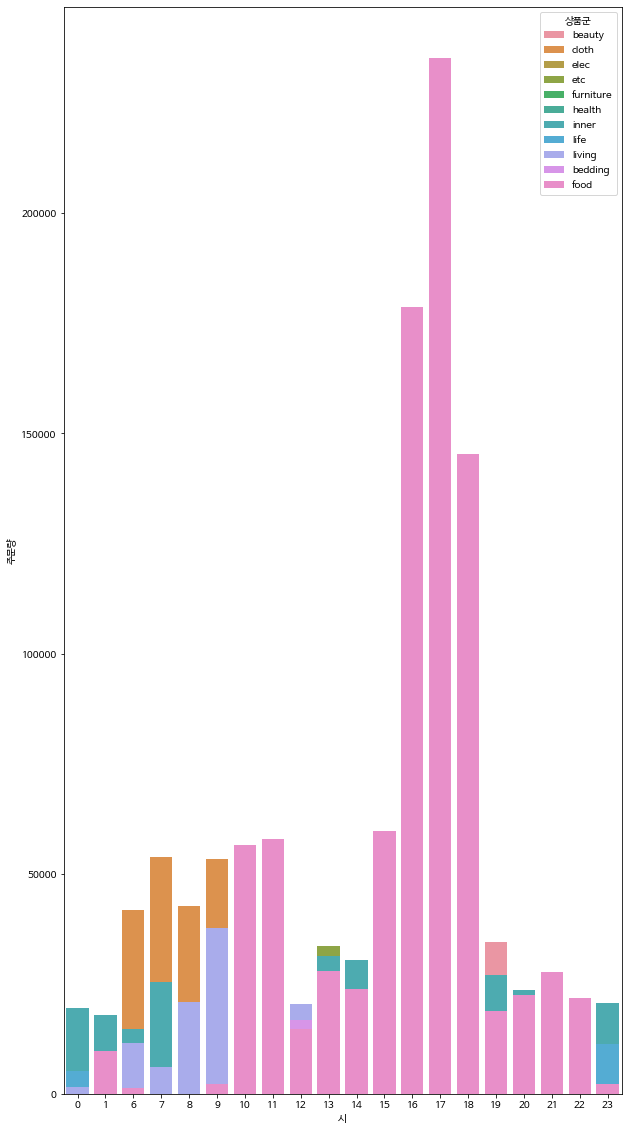

In [37]:
plt.figure(figsize=(10,20))
sns.barplot(data=HourGroup, x='시', y='주문량', hue='상품군', dodge=False)

In [38]:
train['new판매단가'] = np.log(train['판매단가'])
train.drop('판매단가', inplace=True, axis=1)

In [39]:
np.corrcoef(train['주문량'],train['new판매단가'])

array([[ 1.        , -0.61081947],
       [-0.61081947,  1.        ]])

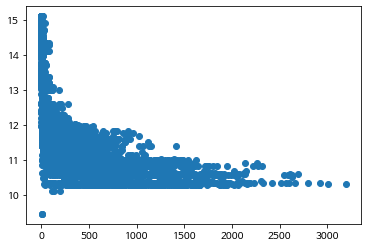

In [40]:
plt.scatter(train['주문량'], (train['new판매단가'])) 

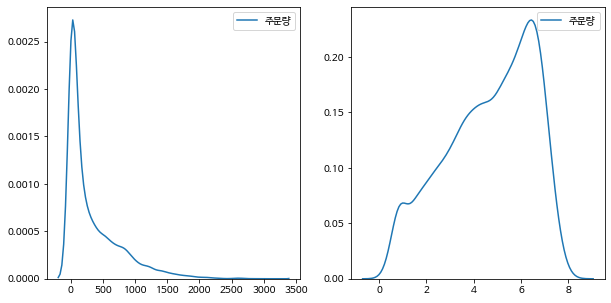

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.kdeplot(train['주문량'], ax=ax[0]) #커널 밀도추정
sns.kdeplot(np.log(train['주문량']), ax=ax[1])

In [42]:
train['new주문량'] = np.log(train['주문량'])
train.drop('주문량', inplace=True, axis=1)

# 모델학습 데이터 생성 및 분리

- 시간대

In [43]:
time = train.groupby('HOUR').aggregate(np.mean)

time_rank = {}
rank = 1 
for idx, row in time.sort_values(by='new주문량').iterrows():
    time_rank[idx] = rank
    rank += 1

In [44]:
prime_time = []

for idx, row in train.iterrows():
    prime_time.append(time_rank[row.HOUR])
    
train['prime_time'] = prime_time

- 요일

In [45]:
day = train.groupby('요일').aggregate(np.mean)

day_rank = {}
rank = 1 
for idx, row in day.sort_values(by='new주문량').iterrows():
    day_rank[idx] = rank
    rank += 1
    
prime_day = []

for idx, row in train.iterrows():
    prime_day.append(day_rank[row.요일])
    
train['prime_day'] = prime_day

- 요일

In [46]:
intercode = set(test['마더코드'].unique()).intersection(set(train['마더코드'].unique()))
interitem = train[train['마더코드'].isin(intercode)]

- test랑 겹치는 마더코드

In [47]:
code = interitem.groupby('마더코드').aggregate(np.mean)

code_rank = {}
rank = 1
for idx, row in code.sort_values(by='new주문량').iterrows():
    code_rank[idx] = rank
    rank += 1

top_code = []

for idx, row in train.iterrows():
    if row.마더코드 in code_rank.keys():
        top_code.append(code_rank[row.마더코드])
    else:
        top_code.append(0)
        
train['top_code'] = top_code

- 분류기준 top_분류

In [48]:
cat = train.groupby('분류').aggregate(np.mean)

cat_rank = {}
rank = 1
for idx, row in cat.sort_values(by='new주문량').iterrows():
    cat_rank[idx] = rank
    rank += 1

top_cat = []

for idx, row in train.iterrows():
    top_cat.append(cat_rank[row.분류])
    
train['top_cat'] = top_cat

- 성은님코드 : 분류원핫+pca
- 회선 : 빈도수인코딩

In [49]:
# 원핫+PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

In [50]:
enc1 = OneHotEncoder()
category = np.array(train['분류'])
category = category.reshape(-1, 1)

In [51]:
enc1.fit(category)
category_ = enc1.transform(category).toarray()

In [52]:
pca = PCA(n_components=2)
res = pca.fit_transform(category_)
res = pd.DataFrame(res, columns=['x1_cat','x2_cat'])

In [53]:
train['x1_cat'] = res['x1_cat']
train['x2_cat'] = res['x2_cat']

In [54]:
train['x1_cat']

0      -0.005480
1      -0.005480
2      -0.005480
3      -0.076982
4      -0.076982
          ...   
7508   -0.011935
7509   -0.004934
7510   -0.004934
7511   -0.004934
7512   -0.004934
Name: x1_cat, Length: 7513, dtype: float64

- 실제날씨(서울)

In [55]:
real = train.groupby('실제_서울_날씨').aggregate(np.mean)

real_rank = {}
rank = 1
for idx, row in real.sort_values(by='new주문량').iterrows():
    real_rank[idx] = rank
    rank += 1

top_real_weather = []

for idx, row in train.iterrows():
    top_real_weather.append(real_rank[row.실제_서울_날씨])
    
train['top_real_weather'] = top_real_weather

-실제날씨 통합

In [56]:
real_total_weather = pd.read_excel('/content/drive/My Drive/빅콘폴더/날씨_실제/날씨통합.xlsx')
real_total_weather

,최고기온,최저기온,강수량,평균풍속
0,27.266667,16.766667,0.8,2.200000
1,27.266667,16.766667,0.8,2.200000
2,27.266667,16.766667,0.8,2.200000
3,27.266667,16.766667,0.8,2.200000
4,27.266667,16.766667,0.8,2.200000
...,...,...,...,...
7508,28.100000,17.133333,0.0,1.466667
7509,28.100000,17.133333,0.0,1.466667
7510,28.100000,17.133333,0.0,1.466667
7511,28.100000,17.133333,0.0,1.466667


In [57]:
train['실제_최고기온'] = real_total_weather['최고기온']
train['실제_최저기온'] = real_total_weather['최저기온']
train['실제_강수량'] = real_total_weather['강수량']
train['실제_평균풍속'] = real_total_weather['평균풍속']

In [58]:
train

,Unnamed: 0,방송일시,노출(분),마더코드,상품코드,상품명,상품군,취급액,날짜,시간,요일,시,holiday,월,holiday(includeSS),실제_서울_최고기온,실제_서울_최저기온,실제_서울_강수량(mm),실제_서울_평균풍속(m/s),실제_서울_날씨,실제_수원_최고기온,실제_수원_최저기온,실제_수원_강수량(mm),실제_수원_평균풍속(m/s),실제_수원_날씨,실제_파주_최고기온,실제_파주_최저기온,실제_파주_강수량(mm),실제_파주_평균풍속(m/s),실제_파주_날씨,예보_서울_강수확률,예보_서울_강수량,예보_서울_하늘상태,예보_서울_일최고기온,예보_서울_일최저기온,예보_일산_강수확률,예보_일산_강수량,예보_일산_일최고기온,예보_일산_일최저기온,예보_수원_강수확률,예보_수원_강수량,예보_수원_일최고기온,예보_수원_일최저기온,계절,DATE,미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),초미세먼지(㎍/㎥),분류,MONTH,HOUR,DAY,Active Users,new판매단가,new주문량,prime_time,prime_day,top_code,top_cat,x1_cat,x2_cat,top_real_weather,실제_최고기온,실제_최저기온,실제_강수량,실제_평균풍속
0,17373,2019-06-15 00:00:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,16517000,2019-06-15,00:00:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0000,8.986486,0.078947,25.105263,16.0000,8.513514,0.078947,26.263158,16.00,2,20190615,36.00,21.36,0.04308,0.01296,0.364,0.0030,f1,6,0,sat,118574.0,11.686879,4.933022,7,1,0,45,-0.005480,0.006940,1,27.266667,16.766667,0.8,2.200000
1,17374,2019-06-15 00:20:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,44829000,2019-06-15,00:20:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0000,8.986486,0.078947,25.105263,16.0000,8.513514,0.078947,26.263158,16.00,2,20190615,36.00,21.36,0.04308,0.01296,0.364,0.0030,f1,6,0,sat,118574.0,11.686879,5.931487,7,1,0,45,-0.005480,0.006940,1,27.266667,16.766667,0.8,2.200000
2,17375,2019-06-15 00:40:00,20.0,100305,200981,오모떼 미라클쉐이핑 브라팬티 시즌3,inner,56057000,2019-06-15,00:40:00,5,0,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0000,8.986486,0.078947,25.105263,16.0000,8.513514,0.078947,26.263158,16.00,2,20190615,36.00,21.36,0.04308,0.01296,0.364,0.0030,f1,6,0,sat,118574.0,11.686879,6.155001,7,1,0,45,-0.005480,0.006940,1,27.266667,16.766667,0.8,2.200000
3,17376,2019-06-15 01:00:00,30.0,100374,201202,USPA 남성 폴로셔츠 위켄드 컬렉션 3종,cloth,9996000,2019-06-15,01:00:00,5,1,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0000,8.986486,0.078947,25.105263,16.0000,8.513514,0.078947,26.263158,16.00,2,20190615,36.00,21.36,0.04308,0.01296,0.364,0.0030,g11,6,1,sat,118574.0,11.141862,4.975834,6,1,0,32,-0.076982,0.135997,1,27.266667,16.766667,0.8,2.200000
4,17377,2019-06-15 01:00:00,30.0,100374,201206,USPA 여성 폴로셔츠 위켄드 컬렉션 3종,cloth,9409000,2019-06-15,01:00:00,5,1,0,6,1,27.4,17.9,2.1,2.5,구름조금/비/천둥번개,26.8,17.1,0.3,2.4,구름조금/소나기/안개,27.6,15.3,0.0,1.7,구름조금/비,10.337838,0.210526,1.925676,26.368421,17.0000,8.986486,0.078947,25.105263,16.0000,8.513514,0.078947,26.263158,16.00,2,20190615,36.00,21.36,0.04308,0.01296,0.364,0.0030,g11,6,1,sat,118574.0,11.141862,4.915315,6,1,0,32,-0.076982,0.135997,1,27.266667,16.766667,0.8,2.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,25398,2019-08-31 23:00:00,20.0,100205,200739,보루네오 루나시즌2 유로탑 멀티수납형 LED침대 킹,furniture,52265000,2019-08-31,23:00:00,5,23,0,8,1,28.9,18.5,0.0,1.8,구름조금,27.7,17.4,0.0,1.7,구름조금/비,27.7,15.5,0.0,0.9,맑음,22.229730,0.000000,3.222973,29.000000,20.3125,17.567568,0.000000,28.210526,18.0625,24.256757,0.131579,28.578947,19.75,2,20190831,16.56,9.36,0.03184,0.01672,0.384,0.0034,a1,8,23,sat,149965.0,13.381646,4.390192,3,1,9,7,-0.011935,0.015644,17,28.100000,17.133333,0.0,1.466667
7509,25399,2019-08-31 23:20:00,20.0,100292,200945,[가이거] 블랙 에디션 다이아몬드 워치(여성용),etc,7047000,2019-08-31,23:20:00,5,23,0,8,1,28.9,18.5,0.0,1.8,구름조금,27.7,17.4,0.0,1.7,구름조금/비,27.7,15.5,0.0,0.9,맑음,22.229730,0.000000,3.222973,29.000000,20.3125,17.567568,0.000000,28.210526,18.0625

In [59]:
#corr_mat = train.corr()
#corr_mat['new주문량'].sort_values(ascending=False)

In [60]:
# train.drop(['Unnamed: 0', '방송일시', '상품명', '상품군', 'holiday', '요일', 'HOUR', '마더코드'], inplace=True, axis=1)
# 방송일시, 상품명, 상품군, holiday(주말), 요일, HOUR, 마더코드

# Feature Engineering & 인코딩

In [61]:
# 빈도수인코딩(위의 원핫+pca와 비교해보기)
def add_frequency_encoding(data,column): #데이터프레임,열을 받아서 빈도수인코딩열을 추가해줌
  enc_nom = (data.groupby(column).size())/len(data)
  data['freq_encode_{}'.format(column)] = data[column].apply(lambda x:enc_nom[x])
  print("freq_encode column was added")

In [62]:
add_frequency_encoding(train,'분류')

freq_encode column was added


# 모델 생성 및 학습

- train, test split

In [63]:
'''
# 통째로 split할경우 실행

from sklearn.model_selection import train_test_split

total_x = train.drop('new주문량', axis=1)
total_y = train['new주문량']

total_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)
'''

"\n# 통째로 split할경우 실행\n\nfrom sklearn.model_selection import train_test_split\n\ntotal_x = train.drop('new주문량', axis=1)\ntotal_y = train['new주문량']\n\ntotal_x_train, total_x_val, total_y_train, total_y_val = train_test_split(x, y, test_size=0.33, random_state=1234)\n"

In [64]:
#모든 카테고리에 대해 따로따로 자동 변수생성
category_list = train['상품군'].unique().tolist()
for i in category_list:
  globals()['x_{}'.format(i)] = train.loc[train['상품군']==i] #카테고리에 해당하는 주문량제외 train데이터 할당
  globals()['y_{}'.format(i)] = train['new주문량'].loc[train['상품군']==i] #카테고리에 해당하는 train의 주문량을 할당

In [65]:
for i in range(11):
  print('x_{}'.format(category_list[i])) #11개 상품군 다 성공적으로 변수 생성됨.

x_inner
x_cloth
x_elec
x_living
x_food
x_health
x_bedding
x_furniture
x_beauty
x_etc
x_life


In [66]:
#카테고리별로 x,y를 train test 스플릿해줌.
from sklearn.model_selection import train_test_split
for i in category_list:
  x_for_split = globals()['x_{}'.format(i)]
  y_for_split = globals()['y_{}'.format(i)]
  globals()['x_train_{}'.format(i)], globals()['x_test_{}'.format(i)], globals()['y_train_{}'.format(i)], globals()['y_test_{}'.format(i)] = train_test_split(x_for_split, y_for_split, test_size=0.33, random_state=1234)
# 카테고리별로 X_train_카테고리 , X_test_카테고리, Y_train_카테고리, Y_test_카테고리 생성됐음.

In [67]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=1234)

In [153]:
seungen_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량',
       '예보_서울_하늘상태', '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량',
       '예보_일산_일최고기온', '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']

In [154]:
feature_selection = x_train_beauty.loc[:,seungen_feature].columns.values
feature_selection

array(['노출(분)', 'holiday(includeSS)', '실제_최고기온', '실제_최저기온', '실제_강수량',
       '실제_평균풍속', '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', '예보_서울_일최고기온',
       '예보_서울_일최저기온', '예보_일산_강수확률', '예보_일산_강수량', '예보_일산_일최고기온',
       '예보_일산_일최저기온', '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
       '예보_수원_일최저기온', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat'], dtype=object)

In [155]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)] = globals()['x_train_{}'.format(i)][feature_selection]
  globals()['shop_test_x_{}'.format(i)] = globals()['x_test_{}'.format(i)][feature_selection]

- 다중공선성 확인하기

In [71]:
hi_feature = ['노출(분)', 'holiday(includeSS)','실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속' , '예보_서울_강수확률', '예보_서울_강수량', 'Active Users', 'new판매단가', 'prime_time',
       'prime_day', 'top_code', 'top_cat']
#실제날씨만 남겨놓은 Feature군

In [72]:
mung = shop_train_x_beauty[hi_feature]
mung

,노출(분),holiday(includeSS),실제_최고기온,실제_최저기온,실제_강수량,실제_평균풍속,예보_서울_강수확률,예보_서울_강수량,Active Users,new판매단가,prime_time,prime_day,top_code,top_cat
3451,20.0,1,31.600000,25.033333,0.600000,3.033333,31.959459,2.039474,139892.0,10.594132,17,1,0,62
866,30.0,0,30.533333,18.900000,0.000000,1.700000,6.148649,0.000000,123984.0,10.998761,5,3,39,57
3603,20.0,1,27.433333,23.666667,7.900000,2.000000,22.297297,0.000000,125507.0,10.591622,18,4,55,77
6571,10.0,0,30.366667,23.266667,0.533333,1.166667,14.256757,0.197368,142358.0,10.594132,6,2,0,35
4443,10.0,0,30.766667,25.500000,12.366667,3.233333,35.810811,5.065789,140823.0,10.594132,17,7,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7276,20.0,0,26.600000,19.300000,22.533333,2.066667,14.932432,0.921053,146126.0,10.911445,6,5,39,57
1907,30.0,0,34.366667,19.233333,0.000000,1.333333,5.067568,0.000000,149290.0,10.998761,9,6,39,57
1341,20.0,1,26.600000,19.533333,2.066667,1.100000,12.702703,0.263158,127810.0,10.591622,8,1,55,77
7406,20.0,0,26.633333,17.900000,0.066667,2.033333,15.675676,0.263158,151192.0,10.896739,8,6,53,77


In [73]:
mung.corr()

,노출(분),holiday(includeSS),실제_최고기온,실제_최저기온,실제_강수량,실제_평균풍속,예보_서울_강수확률,예보_서울_강수량,Active Users,new판매단가,prime_time,prime_day,top_code,top_cat
노출(분),1.000000,0.075588,-0.197778,-0.443136,-0.047173,-0.055341,-0.053630,-0.167876,-0.298200,0.395518,-0.043710,-0.120469,0.451003,0.425998
holiday(includeSS),0.075588,1.000000,0.115520,0.123062,0.115415,0.221564,0.046013,-0.028240,0.117880,0.038201,0.122156,-0.494191,0.040438,0.235093
실제_최고기온,-0.197778,0.115520,1.000000,0.457915,-0.321804,0.057443,0.077372,0.133015,0.440530,-0.094916,0.219294,0.012521,-0.074277,-0.113747
실제_최저기온,-0.443136,0.123062,0.457915,1.000000,0.252393,0.266731,0.457587,0.517829,0.495921,-0.291189,0.343216,-0.036499,-0.139036,-0.149411
실제_강수량,-0.047173,0.115415,-0.321804,0.252393,1.000000,0.137233,0.290243,0.224324,0.083107,-0.123388,-0.068536,0.062248,0.034802,0.053999
실제_평균풍속,-0.055341,0.221564,0.057443,0.266731,0.137233,1.000000,0.175323,0.024852,-0.003540,0.013895,0.166600,-0.046038,-0.128122,0.006515
예보_서울_강수확률,-0.053630,0.046013,0.077372,0.457587,0.290243,0.175323,1.000000,0.807337,0.114491,-0.050071,0.275830,0.033456,-0.047886,0.055249
예보_서울_강수량,-0.167876,-0.028240,0.133015,0.517829,0.224324,0.024852,0.807337,1.000000,0.227130,-0.166309,0.226400,-0.052493,0.038618,0.041889
Active Users,-0.298200,0.117880,0.440530,0.495921,0.083107,-0.003540,0.114491,0.227130,1.000000,0.097189,0.179757,0.069999,-0.056246,-0.109068
new판매단가,0.395518,0.038201,-0.094916,-0.291189,-0.123388,0.013895,-0.050071,-0.166309,0.097189,1.000000,-0.210436,-0.012434,-0.286389,-0.397504


In [74]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
shop_train_x_corr = mung.corr()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


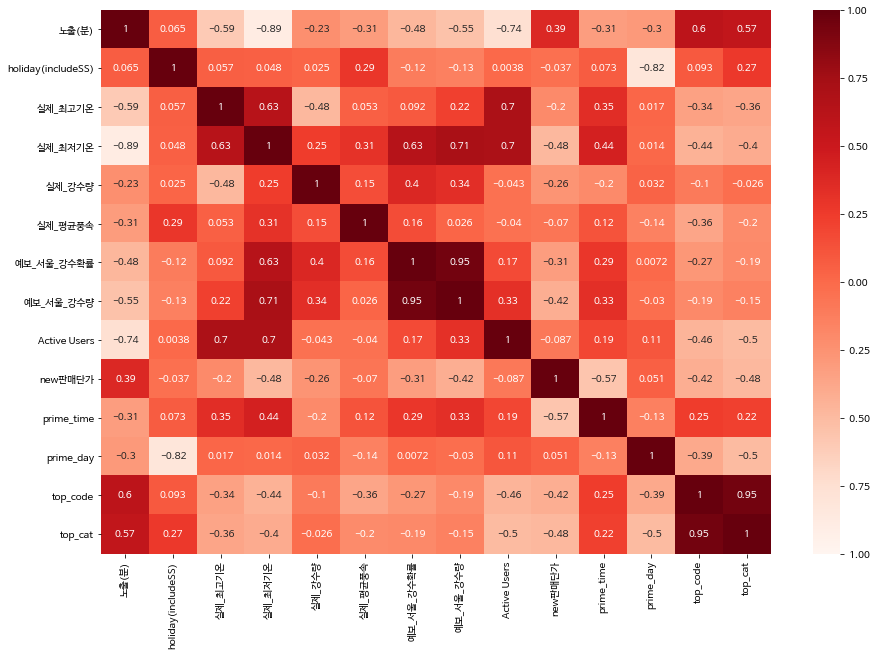

In [75]:
plt.rcParams['figure.figsize']=(15,10)

sns.heatmap(shop_train_x_corr.corr(),
          annot=True,
          cmap='Reds',
          vmin = -1, vmax = 1
          )

In [76]:
# 피처마다의 VIF 계수를 출력
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(shop_train_x_corr.values, i) for i in range(shop_train_x_corr.shape[1])]
vif["features"] = shop_train_x_corr.columns
vif # 기존 feature_selection대로하면 다 엄청 높게나옴 +e3...이런식

,VIF Factor,features
0,42.645496,노출(분)
1,8.137521,holiday(includeSS)
2,12.734488,실제_최고기온
3,46.758174,실제_최저기온
4,9.025316,실제_강수량
5,3.686745,실제_평균풍속
6,71.661523,예보_서울_강수확률
7,61.089340,예보_서울_강수량
8,23.941586,Active Users
9,54.038453,new판매단가


- 랜포돌리기

In [156]:
forest.fit(shop_train_x_beauty, y_train_beauty)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

In [157]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [158]:
predictions = forest.predict(shop_train_x_beauty)
mape = mean_absolute_percentage_error(y_train_beauty, predictions)
mape

4.194052260626042

In [80]:
some_data = x_train_beauty.iloc[:8] # 8개의 Data의 주문량 예측해 보겠음.
some_labels = y_train_beauty.iloc[:8]
some_data = some_data[feature_selection]
print("예측", forest.predict(some_data))
print("레이블:", list(some_labels))

예측 [6.39418937 6.69611287 7.14041626 4.81628145 5.97025984 5.76505381
 6.40335998 6.59707143]
레이블: [5.984548455409607, 7.032042571247125, 7.160369810952259, 4.98884573174533, 6.339727012180498, 5.412054715530526, 6.553619481562081, 6.86931392306804]


#모든 카테고리 반복문으로 한번에 fit & predict 결과

In [149]:
mape_score = []
for i in category_list:
  category_data = globals()['shop_train_x_{}'.format(i)]
  category_label =  globals()['y_train_{}'.format(i)]
  forest.fit(category_data,category_label)
  predictions = forest.predict(category_data)
  mape_score.append(mean_absolute_percentage_error(category_label, predictions))

In [150]:
for i in range(len(category_list)):
  print("RF MAPE score of",category_list[i],":",mape_score[i])

RF MAPE score of inner : 6.430470139678443
RF MAPE score of cloth : 8.696780083549188
RF MAPE score of elec : 30.54951399156172
RF MAPE score of living : 14.438414922304002
RF MAPE score of food : 3.6409459237219695
RF MAPE score of health : 6.8749586854201805
RF MAPE score of bedding : 9.41152347855117
RF MAPE score of furniture : 34.11458070842108
RF MAPE score of beauty : 4.192331478933685
RF MAPE score of etc : 24.445281122442907
RF MAPE score of life : 16.364889071001016


In [83]:
pd.Series(mape_score).mean()

10.08734071706689

- 특성중요도 시각화

특성 중요도:
[0.00768244 0.00680413 0.01583689 0.01182868 0.02188272 0.04658281
 0.0073894  0.0101629  0.01013642 0.02592406 0.01012624 0.01157399
 0.00660014 0.01743384 0.00937099 0.01427364 0.00815553 0.01244292
 0.00880054 0.09595866 0.03143935 0.0378612  0.0196986  0.01239718
 0.53963675]


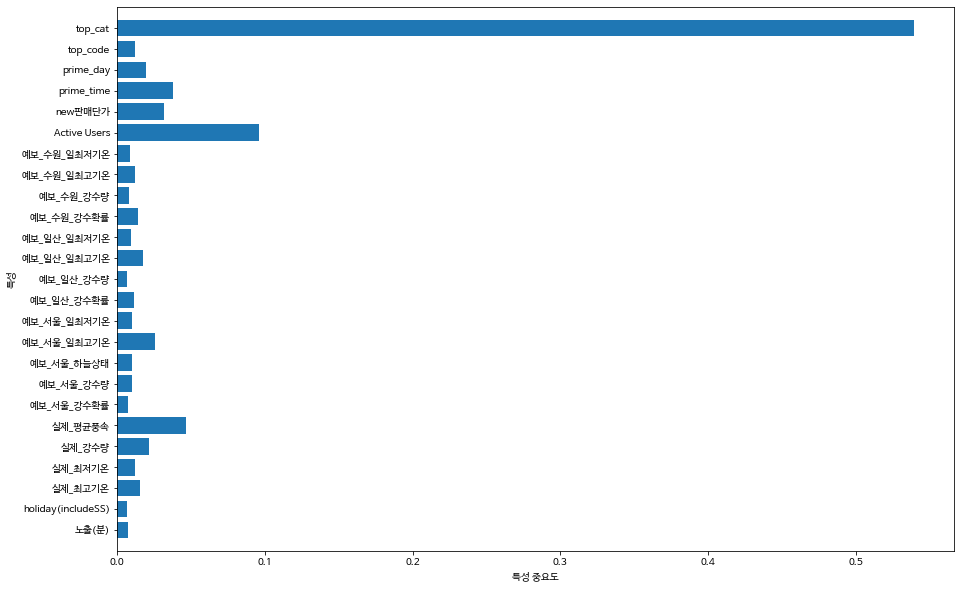

In [161]:
print("특성 중요도:\n{}".format(forest.feature_importances_))

def plot_feature_importances_NS(view_data,model):
    n_features = view_data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), view_data.columns.tolist())
    plt.xlabel("특성 중요도")
    plt.ylabel("특성")
    plt.ylim(-1, n_features)

plot_feature_importances_NS(shop_train_x_life,forest) #다들 top_cat가 가장 유효하게 작용한것 같다.

In [162]:
forest.feature_importances_

array([0.00768244, 0.00680413, 0.01583689, 0.01182868, 0.02188272,
       0.04658281, 0.0073894 , 0.0101629 , 0.01013642, 0.02592406,
       0.01012624, 0.01157399, 0.00660014, 0.01743384, 0.00937099,
       0.01427364, 0.00815553, 0.01244292, 0.00880054, 0.09595866,
       0.03143935, 0.0378612 , 0.0196986 , 0.01239718, 0.53963675])

# SVM적용

In [85]:
from sklearn.svm import LinearSVR

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
scaler = MinMaxScaler()

- 모든 카테고리에 대해 svr 써보기

In [86]:
'''
svm_reg = LinearSVR()
mape_score_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_reg.fit(category_data,category_label)
  predictions = svm_reg.predict(category_data)
  mape_score_svr.append(mean_absolute_percentage_error(category_label, predictions))
'''

"\nsvm_reg = LinearSVR()\nmape_score_svr = []\nfor i in category_list:\n  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])\n  category_label =  globals()['y_train_{}'.format(i)]\n  svm_reg.fit(category_data,category_label)\n  predictions = svm_reg.predict(category_data)\n  mape_score_svr.append(mean_absolute_percentage_error(category_label, predictions))\n"

In [87]:
'''
for i in range(len(category_list)):
  print("SVM MAPE score of",category_list[i],":",mape_score_svr[i])
'''

'\nfor i in range(len(category_list)):\n  print("SVM MAPE score of",category_list[i],":",mape_score_svr[i])\n'

- Poly SVM

In [88]:
from sklearn.svm import SVR

In [89]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1)
svm_poly_reg1.fit(std_scaler.fit_transform(shop_train_x_beauty), y_train_beauty)

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [90]:
predictions_poly_svm = svm_poly_reg1.predict(std_scaler.fit_transform(shop_train_x_beauty))
mape_poly = mean_absolute_percentage_error(y_train_beauty, predictions_poly_svm)
mape_poly

4.005903577490081

In [91]:
svm_poly_reg1 = SVR(kernel="poly", gamma='auto', degree=3, C=100, epsilon=0.1) # degree에 따라 성능차이 조금씩 난다. 3차정도가 최적인듯(4차가 성능은 경미하게 좋음)
mape_score_poly_svr = []
for i in category_list:
  category_data = std_scaler.fit_transform(globals()['shop_train_x_{}'.format(i)])
  category_label =  globals()['y_train_{}'.format(i)]
  svm_poly_reg1.fit(category_data,category_label)
  predictions = svm_poly_reg1.predict(category_data)
  mape_score_poly_svr.append(mean_absolute_percentage_error(category_label, predictions))

In [92]:
for i in range(len(category_list)):
  print("Poly_SVM MAPE score of",category_list[i],":",mape_score_poly_svr[i])

Poly_SVM MAPE score of inner : 6.741541916611923
Poly_SVM MAPE score of cloth : 7.984467061397986
Poly_SVM MAPE score of elec : 24.85330255406707
Poly_SVM MAPE score of living : 13.619675732531942
Poly_SVM MAPE score of food : 3.5424667953382114
Poly_SVM MAPE score of health : 5.702100077873844
Poly_SVM MAPE score of bedding : 8.573747757653567
Poly_SVM MAPE score of furniture : 28.415405930324393
Poly_SVM MAPE score of beauty : 4.005903577490081
Poly_SVM MAPE score of etc : 23.87165370658303
Poly_SVM MAPE score of life : 14.185797363360287


In [93]:
pd.Series(mape_score_poly_svr).mean()

12.863278406657486

# 카테고리별 dnn

In [94]:
shop_train_x_beauty.describe()

,노출(분),holiday(includeSS),실제_최고기온,실제_최저기온,실제_강수량,실제_평균풍속,예보_서울_강수확률,예보_서울_강수량,예보_서울_하늘상태,예보_서울_일최고기온,예보_서울_일최저기온,예보_일산_강수확률,예보_일산_강수량,예보_일산_일최고기온,예보_일산_일최저기온,예보_수원_강수확률,예보_수원_강수량,예보_수원_일최고기온,예보_수원_일최저기온,Active Users,new판매단가,prime_time,prime_day,top_code,top_cat
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,19.625000,0.236111,30.152315,21.521991,4.734028,1.738889,24.334159,2.904605,2.809174,30.554946,22.511285,23.284669,2.756122,29.397498,21.310706,23.510351,2.692160,30.333821,22.180671,141077.055556,10.769065,10.402778,4.319444,32.013889,60.826389
std,4.938609,0.426174,2.853354,2.740394,10.834913,0.561204,14.675362,4.262252,0.805093,2.013130,2.416658,14.894398,4.343389,1.966414,2.654014,14.602633,4.510084,1.957804,2.574818,13564.996281,0.227243,4.608171,2.054001,22.937430,14.929826
min,5.000000,0.000000,24.100000,16.600000,0.000000,0.933333,1.621622,0.000000,1.162162,26.473684,18.000000,1.621622,0.000000,24.947368,16.312500,1.621622,0.000000,26.631579,17.437500,110345.000000,10.591622,1.000000,1.000000,0.000000,28.000000
25%,20.000000,0.000000,27.966667,19.233333,0.000000,1.333333,12.550676,0.197368,2.172297,29.263158,20.312500,10.135135,0.000000,28.184211,18.750000,13.006757,0.131579,29.315789,19.750000,130279.000000,10.591622,7.000000,3.000000,0.000000,55.000000
50%,20.000000,0.000000,29.966667,21.633333,0.066667,1.700000,24.290541,1.315789,3.033784,30.210526,22.437500,22.905405,0.986842,28.894737,21.000000,24.594595,1.381579,30.000000,21.875000,142358.000000,10.594132,9.000000,4.000000,39.000000,62.000000
75%,20.000000,0.000000,31.966667,24.208333,4.533333,1.933333,32.770270,3.980263,3.439189,31.657895,24.937500,32.364865,3.315789,30.421053,24.000000,30.608108,3.141447,31.486842,25.000000,150976.750000,10.985293,15.250000,6.000000,55.000000,77.000000
max,30.000000,1.000000,35.733333,25.500000,85.166667,3.300000,81.621622,29.078947,4.000000,36.631579,26.437500,81.621622,29.078947,34.842105,25.000000,83.513514,30.789474,34.842105,26.000000,169626.000000,11.288531,19.000000,7.000000,55.000000,77.000000


In [95]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [96]:
reg_col = ['실제_최고기온','실제_최저기온','실제_강수량','실제_평균풍속', 
           '예보_서울_강수확률', '예보_서울_강수량', '예보_서울_하늘상태', 
           '예보_서울_일최고기온', '예보_서울_일최저기온', '예보_일산_강수확률', 
           '예보_일산_강수량', '예보_일산_일최고기온', '예보_일산_일최저기온', 
           '예보_수원_강수확률', '예보_수원_강수량', '예보_수원_일최고기온',
           '예보_수원_일최저기온', 'new판매단가']

In [97]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [98]:
for i in category_list:
  globals()['shop_train_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_train_x_{}'.format(i)][reg_col])
  globals()['shop_test_x_{}'.format(i)][reg_col] = scaler.fit_transform(globals()['shop_test_x_{}'.format(i)][reg_col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [99]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [100]:
n_inputs = 18
n_h1 = 50
n_h2 = 50
n_outputs = 1

#### optimizer = sgd

m1 = Sequential()
m1.add(Dense(n_h1, input_dim=18, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_h2, input_dim=n_h1, kernel_initializer='normal', activation='relu'))
m1.add(Dense(n_outputs, input_dim=n_h2, kernel_initializer='normal'))

In [101]:
m1.compile(optimizer='adam', loss='mean_squared_error')
hist1=m1.fit(shop_train_x_bedding[reg_col], y_train_bedding, epochs=20, batch_size=20)

Epoch 1/20
10/10 [==============================] - 0s 1ms/step - loss: 24.5977
Epoch 2/20
10/10 [==============================] - 0s 1ms/step - loss: 23.7996
Epoch 3/20
10/10 [==============================] - 0s 1ms/step - loss: 22.1756
Epoch 4/20
10/10 [==============================] - 0s 1ms/step - loss: 19.0600
Epoch 5/20
10/10 [==============================] - 0s 2ms/step - loss: 14.1253
Epoch 6/20
10/10 [==============================] - 0s 1ms/step - loss: 8.0450
Epoch 7/20
10/10 [==============================] - 0s 1ms/step - loss: 3.7814
Epoch 8/20
10/10 [==============================] - 0s 1ms/step - loss: 2.8572
Epoch 9/20
10/10 [==============================] - 0s 2ms/step - loss: 2.7941
Epoch 10/20
10/10 [==============================] - 0s 1ms/step - loss: 2.4893
Epoch 11/20
10/10 [==============================] - 0s 1ms/step - loss: 2.3358
Epoch 12/20
10/10 [==============================] - 0s 1ms/step - loss: 2.2063
Epoch 13/20
10/10 [=========================

In [102]:
pred_cate = []
m1.compile(optimizer='adam', loss='mean_squared_error')
for i in category_list:
  hist1=m1.fit(globals()['shop_train_x_{}'.format(i)][reg_col], globals()['y_train_{}'.format(i)], epochs=20, batch_size=20)
  pred_cate.append(m1.predict(globals()['shop_train_x_{}'.format(i)][reg_col]))

Epoch 1/20
30/30 [==============================] - 0s 1ms/step - loss: 2.4886
Epoch 2/20
30/30 [==============================] - 0s 1ms/step - loss: 2.2007
Epoch 3/20
30/30 [==============================] - 0s 1ms/step - loss: 1.9916
Epoch 4/20
30/30 [==============================] - 0s 1ms/step - loss: 1.8815
Epoch 5/20
30/30 [==============================] - 0s 1ms/step - loss: 1.7617
Epoch 6/20
30/30 [==============================] - 0s 1ms/step - loss: 1.6286
Epoch 7/20
30/30 [==============================] - 0s 1ms/step - loss: 1.5901
Epoch 8/20
30/30 [==============================] - 0s 1ms/step - loss: 1.4945
Epoch 9/20
30/30 [==============================] - 0s 1ms/step - loss: 1.4065
Epoch 10/20
30/30 [==============================] - 0s 1ms/step - loss: 1.3386
Epoch 11/20
30/30 [==============================] - 0s 1ms/step - loss: 1.2922
Epoch 12/20
30/30 [==============================] - 0s 1ms/step - loss: 1.2720
Epoch 13/20
30/30 [==============================

In [103]:
pred = m1.predict(shop_train_x_bedding[reg_col])

In [104]:
mape_dnn = mean_absolute_percentage_error(y_train_bedding, pred)
mape_dnn

24.648135417443154

In [105]:
mape_dnn_cate = []
num = 0
for i in category_list:
  mape_dnn_cate.append(mean_absolute_percentage_error((globals()['y_train_{}'.format(i)]),pred_cate[num]))
  num += 1

In [106]:
for i in range(len(category_list)):
  print("DNN MAPE score of:",category_list[i],":",mape_dnn_cate[i])

DNN MAPE score of: inner : 18.191742605767843
DNN MAPE score of: cloth : 34.65108869478195
DNN MAPE score of: elec : 67.1960132306311
DNN MAPE score of: living : 29.62149396140562
DNN MAPE score of: food : 7.177551804395491
DNN MAPE score of: health : 17.036938778671914
DNN MAPE score of: bedding : 16.488362940792836
DNN MAPE score of: furniture : 49.2430906373907
DNN MAPE score of: beauty : 10.528048993281871
DNN MAPE score of: etc : 103.32058169578244
DNN MAPE score of: life : 35.79147585483501


In [107]:
pd.Series(mape_dnn_cate).mean()

35.38603538161244